# MBA FIAP Inteligência Artificial & Machine Learning

<p align="center">
<img src="imagens/smart-hiring.jpg">
</p>

## Tecnologia de Processamento de Imagens
## Projeto Final Smart-Hiring: Entrevista Virtual

Este projeto final tem como objetivo explorar os conhecimentos adquiridos nas aulas práticas. Por meio uma trilha guiada para construir uma aplicação que tem por objetivo analisar imagens e extrair uma série de informações que serão utilizadas para compor uma análise de seleção de candidatos para uma entrevista simulada.

Este projeto poderá ser feita por grupos de até 4 pessoas.

| Nome dos Integrantes               | RM            | Turma |
| :--------------------------------- | :------------ | :---: |
| Rafael Loureiro Ferreira Silva     | RM 330357     | `1IA` |
| Juliano Costa                      | RM 330305     | `1IA` |

Por ser um projeto guiado, fique atento quando houver as marcações **Implementação** indica que é necessário realizar alguma implementação em Python no bloco a seguir onde há a inscrição ```## IMPLEMENTAR``` e **Resposta** indica que é esperado uma resposta objetiva relacionado a algum questionamento. 

**Cada grupo pode utilizar nas respostas objetivas quaisquer itens necessários que enriqueçam seu ponto vista, como gráficos, fotos e, até mesmo, trechos de código-fonte.**

Pode-se utilizar quantos blocos forem necessários para realizar determinadas implementações ou utilizá-las para justificar as respostas. Não é obrigatório utilizar somente o bloco indicado.

Ao final não se esqueça de subir os arquivos do projeto nas contas do GitHub de cada membro, ou subir na do representante do grupo e os membros realizarem o fork do projeto.

A avaliação terá mais ênfase nos seguintes tópicos de desenvolvimento do projeto:
 
1. __Detector de objeto (cartão de identificação)__
2. __Detector de faces__
3. __Detector de sorriso__
4. __Detector de bocejo__
5. __Detector de olhos fechados__
6. __Descritor de objetos na cena__
7. __Conclusões Finais__


## Introdução

_Disclaimer: as informações do caso de uso de negócio são meramente ilustrativas para aplicar as tecnologias de visão computacional de forma mais aderente ao desafio proposto. Todos os comentários foram forjados para dar vazão aos desafios e não representam formas de avaliação de candidatos. A empresa em questão, a Wandee, é fictícia._

A empresa **Wandee**, especializada em entrevistas virtuais, está construindo um produto minimamente viável (MVP) para testar algumas tecnologias voltadas a visão computacional para tornar o processo de seleção, especialmente a etapa de entrevista mais completo, rápido e que permita aos recrutadores obterem feedbacks mais completos além da profunidade técnica de cada posição, como por exemplo, se o candidato é ele mesmo (prova de identidade), se possuí o cartão de acesso a entrevista, aspectos de atenção durante a entrevista, como concentração e foco. Ainda será analisado questões de organização no local do entrevistado, buscando por objetos na visão da câmera.

Todo o processo de entrevista virtual é feito remotamente por meio de uma câmera (_webcam_). Logo, todos os algoritmos desenvolvidos precisam capturar as imagens desta origem.

## 1. Detector de objeto

Antes de começar com o processo de autenticação, os candidatos precisam utilizar o celular e exibir o ícone da empresa para a câmera. Se o resultado for positivo indica que o sistema pode avançar para a próxima etapa.

<p align="center">
<img src="imagens/logo.png" height="60%" width="60%">
</p>

Construa um algortimo que seja capaz de analisar uma região de interesse específica (ROI, _Region of Interest_), capturada por vídeo, e valide se o ícone está presente ao ser exibido pelo celular do candidato. 

Lembre-se que questões de proporção e rotação precisam ser consideradas na identificação.

Este processo precisa ser de rápida identificação, neste caso não será possível aplicar técnicas que envolvam aprendizado de máquina. É indicado o uso de detectores de objetos e extratores de características.

_No seu smartphone abra o navegador e entre com o link https://raw.githubusercontent.com/michelpf/fiap-ml-tec-proc-imagens-capstone/master/projeto-final/imagens/logo.png_

Ou, escaneie com seu smartphone o QRCode abaixo.

<p align="center">
<img src="imagens/qrcode.png" height="25%" width="25%">
</p>

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from os import listdir
from os.path import isfile, join
from scipy.spatial import distance as dist
import collections
from matplotlib.pyplot import figure

%matplotlib inline

A função abaixo deve receber uma imagem capturada da região de interesse e comparar com a imagem template do logotipo de empresa. O retorno é o número de correspondências encontradas.

In [2]:
def detector(imagem, template):
    # Conversão das imagens para escala de cinza
    imagem_norm = cv2.cvtColor(imagem, cv2.COLOR_BGR2GRAY)
    template_norm = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
    
    # Criação do detector ORB
    orb_detector = cv2.ORB_create(3000)
    
    #aplicação de desfoque gaussiano, sharpening e limiarização para melhorar a detecção do logotipo
    imagem_norm = cv2.GaussianBlur(imagem_norm, (7,7), 0)
    template_norm = cv2.GaussianBlur(template_norm, (7,7), 0)
    
    filter_sharpening = np.array([[-1,-1,-1], [-1, 9, -1], [-1, -1, -1]])
    imagem_norm = cv2.filter2D(imagem_norm, -1, filter_sharpening)
    template_norm = cv2.filter2D(template_norm, -1, filter_sharpening)

    ret, imagem_norm = cv2.threshold(imagem_norm, 120, 255, cv2.THRESH_BINARY)
    ret, template_norm = cv2.threshold(template_norm, 120, 255, cv2.THRESH_BINARY)
    
    kps = orb_detector.detect(template_norm, None)
    kps_target, desc_target = orb_detector.compute(template_norm, kps)
    
    kps = orb_detector.detect(imagem_norm, None)
    kps_search, desc_search = orb_detector.compute(imagem_norm, kps)
    
    FLANN_INDEX_LSH = 6
    FLANN_INDEX_KDTREE = 0

    index_params_orb = dict(algorithm = FLANN_INDEX_LSH, table_number = 6, key_size = 12, multi_probe_level = 1) 
    index_params_surf = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)

    search_params = dict(checks=100)
    
    #utilização de FLANN para fazer o match com KNN
    try:
        flann = cv2.FlannBasedMatcher(index_params_orb, search_params)
        matches = flann.knnMatch(desc_target, desc_search, k=2)
    except:
        return 0
    
    #busca somente os matches bons
    good_matches = []    
    try:
        for i,(m,n) in enumerate(matches):
            if m.distance < 0.75*n.distance:
                good_matches.append(m)
    except:
        pass

    return len(good_matches)

Carregue a imagem de template.

In [3]:
imagem_template = cv2.imread("imagens/logo.png")

Utilize a função ```detector``` para obter as correspondências identificadas. Por meio de testes prévios, estabeleça qual o valor de _matches_ para o template definido. Isto pode fazer com que ajuste valores do detector ORB para ajustes, é um processo de experimentação.

Após definir o limiar, desenvolva uma regra para comparar com o valor de _matches_ e exibir em tempo real se o template foi localizado.

In [4]:
#código utilizado para testar os valores dos matches e definir um limiar
# o limiar definido foi 50
cam_capture = cv2.VideoCapture(0)
cv2.destroyAllWindows()

while True:
    ret, image_frame = cam_capture.read()
    
    if ret:
        matches = detector(image_frame, imagem_template)
        cv2.putText(image_frame, "Matches: " + str(matches), (2,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 6)
        if matches > 50:
            cv2.putText(image_frame, "MATCH!!", (400,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 6)
        cv2.imshow("Detector do logo", image_frame)
        if cv2.waitKey(1) == 13:
            break
    else:
        break
        
cam_capture.release()
cv2.destroyAllWindows()

In [2]:
# Função de suporte para exibição de imagens no Jupyter

def exibir_imagem(imagem):
    figure(num=None, figsize=(15, 10))
    image_plt = mpimg.imread(imagem)
    plt.imshow(image_plt)
    plt.axis('off')
    plt.show()

O trecho de códido abaixo é para iniciar a captura de imagens da câmera. Nela será definido uma região de interesse que deverá ser capturado uma imagem para acionar a função de detecção.

In [9]:
cap = cv2.VideoCapture(0)
cv2.destroyAllWindows()

while True:
    # Obtendo imagem da câmera
    ret, frame = cap.read()
    
    if ret:
        # Definindo região de interesse (ROI)
        height, width = frame.shape[:2]
        top_left_x = int(width / 3)
        top_left_y = int((height / 2) + (height / 4))
        bottom_right_x = int((width / 3) * 2)
        bottom_right_y = int((height / 2) - (height / 4))
    
        # Desenhar retângulo na região de interesse
        cv2.rectangle(frame, (top_left_x,top_left_y), (bottom_right_x,bottom_right_y), 255, 3)

        # Obtendo região de interesse para validação do detector
        cropped = frame[bottom_right_y:top_left_y , top_left_x:bottom_right_x]

        # Executando o detector, definindo um limiar e fazendo a comparação para validar se o logotipo foi detectado
        matches = detector(cropped, imagem_template)
        cv2.putText(frame, "Matches: " + str(matches), (2,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 6)
        if matches > 50:
            cv2.imwrite("imagens/logo_detected.png", cropped)
            break      

        cv2.imshow("Identificacao de Template", frame)
        
    # Se for teclado Enter (tecla 13) deverá sair do loop e encerrar a captura de imagem
    if cv2.waitKey(1) == 13: 
        break

cap.release()
cv2.destroyAllWindows()   

Armazene uma evidência do logotipo detectado, exibindo na imagem a região de interesse com a imagem.

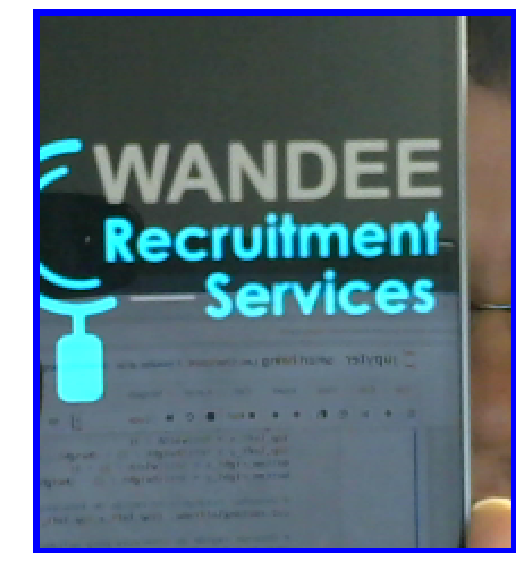

In [10]:
# IMPLEMENTAR
# Passe o parâmetro localização da imagem para exibi-la no notebook
exibir_imagem("imagens/logo_detected.png")

## 2. Detector de faces

Para validação de autenticidade do candidado, o processo de entrevista virtual precisa confirmar se a pessoa selecionada para a entrevista é a mesma. Neste caso a técnica a ser utilizada é por meio de um reconhecimento facial,

Inicialmente, precisamos treinar um classificador próprio do OpenCV com exemplos de imagem do candidato.
Eleja uma pessoa do grupo para ser o candidato e treine um conjunto de imagens suficiente para que seja possível alcançar similaridade, onde o valor de não similaridade seja de até 40 pontos. O algortimo de similaridade de faces utiliza um sistema que quando a face é idêntica, o número de pontos é igual a 0, se for totalmente diferente, tende ao infinito. Logo, patamar de 30 a 40 é um bom número de similaridade.

**Implementação**

Nesta etapa inicial será realizado o treinamento das faces de um determinado candidato.
Você precisará coletar um número de imagens relevante do candidato. Além disso, é recomendável aplicação de um detector de faces para que seja extraído somente a _região de interesse_ ou seja, a própria face. Uma maneira de conseguir este tipo de segmentação é utilizando um classificador em cascada de Haar treinado para este fim.

Utilize a função a abaixo para segmentar o rosto de uma imagem.

In [11]:
face_classifier = cv2.CascadeClassifier('classificadores/haarcascade_frontalface_default.xml')

def face_extractor(img):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces = face_classifier.detectMultiScale(gray, 1.2, 5)
    
    if faces is ():
        return None, None, None, None, None
    
    for (x,y,w,h) in faces:
        cropped_face = img[y:y+h, x:x+w]
        X, Y, W, H = x, y, w, h
        
    return (cropped_face,X,Y,W,H)

Crie um algoritmo para que treine um determinado número de faces, escolhido pelo grupo, par que seja armazenado em um diretório específico para posteior treinamento.

In [15]:
cap = cv2.VideoCapture(0)
cv2.destroyAllWindows()

contagem = 0

# IMPLEMENTAR
# Defina o número máximo de imagens a serem coletadas

contagem_maxima = 30

while True:
    ret, frame = cap.read()

    if ret:
        cv2.imshow("Imagem de Treino", frame)
        
        # IMPLEMENTAR
        # Crie um algoritmo para salvar as imagens segmentadas em face em um determinado diretório
        
        # Se for teclado Enter (tecla 13) deverá sair do loop e encerrar a captura de imagem
        # ou for alcançado a contagem máxima (amostras)
        # Se for tecla espaço detecta a face na imagem e salva em disco
        
        face, x, y, w, h = face_extractor(frame)
        if face is not None:
            cv2.imwrite("imagens/candidato/" + str(contagem) + ".png", face)
            contagem += 1
        
        if cv2.waitKey(1) == 13 or contagem == contagem_maxima:
            break
        
cap.release()
cv2.destroyAllWindows()
print("Coleta de amostras completado")

Coleta de amostras completado


O treinamento utilizando é um próprio classificador de faces que o OpenCV possui. Neste caso vamos optar pelo classificador Local Binary Patterns Histograms (LBPH), que para este cenário é o mais adequado.

O grupo pode optar por escolher outros tipos de algoritmos do OpenCV, se desejarem.

In [16]:
# IMPLEMENTAR
# Defina o diretório utilizado para salvar as faces de exemplo

data_path = "imagens/candidato/"

onlyfiles = [f for f in listdir(data_path) if isfile(join(data_path, f))]
training_data, labels = [], []

for i, files in enumerate(onlyfiles):
    image_path = data_path + onlyfiles[i]
    images = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    training_data.append(images)
    labels.append(0)

# Criando uma matriz da lista de labels
labels = np.asarray(labels, dtype=np.int32)

# Treinamento do modelo
model = cv2.face.LBPHFaceRecognizer_create()
model.train(training_data, labels)

print("Modelo treinado com sucesso.")

# IMPLEMENTAR
# Defina na chave 0 o nome do candidato

persons = {0: "Rafael Loureiro"}

Modelo treinado com sucesso.


Vamos considerar uma classificação com sucesso quando a distândia de predição da face analisada for entre 30 e 40. Os valores de retorno destes classificador não é um índice de confiança.

Quando houver uma deteção dentro da margem de distância, armazene a imagem com o nome "success_candidate.png", constando as informações do nome do candidato e a distância identificada pelo classificador (retorno do método _predict_).

Escreva na tela onde a imagem da câmera é capturada a informação da distância de detecção da face extraída versus a face treinada, emuldure a face num retângulo e, se a face for devidadamente identificada, inclua um texto com a informação "```<Nome do candidato>``` Reconhecido"

In [21]:
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    
    if ret:
        
        # IMPLEMENTAR
        # Extraia a face da imagem obtida da câmera
        # Faça os ajustes necessários para classificá-la no classifcador treinado
        # Estabeleça um algoritmo para concluir se o resultado é 'Sucesso', candidato identificado ou 'Não Indetificado' para
        # quando não for localizado o candidato
        # Analise também situações onde a face não é identificada
        # Utilize a função face_extractor para segmentar a imagem de rosto
        
        face, x, y, w, h = face_extractor(frame)
        
        if face is not None:
            face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
            results = model.predict(face)
            # imprimir o resultado da predição na imagem
            cv2.putText(frame, '{0:.3g}'.format(results[1]), (50,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 3)
            # desenhar retângulo na face
            cv2.rectangle(frame, (x, y), (x + w, y + h), 255, 2)
            if results[1] <= 40:
                # imprimir o nome do candidato e salvar a imagem
                cv2.putText(frame, persons[results[0]], (x, y + h + 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
                cv2.imwrite("imagens/success_candidate.png", frame)
            else:
                # imprimir que o candidato não foi reconhecido
                cv2.putText(frame, "Candidato nao reconhecido", (x - 110, y + h + 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
            
        cv2.imshow("Reconhecimento de face", frame)
        
    # Se for teclado Enter (tecla 13) deverá sair do loop e encerrar a captura de imagem    
    if cv2.waitKey(1) == 13: #13 is the Enter Key
        break
        
cap.release()
cv2.destroyAllWindows()     

Guarde como evidência de classificação bem sucedida, uma imagem capturada da câmera durante o processo.

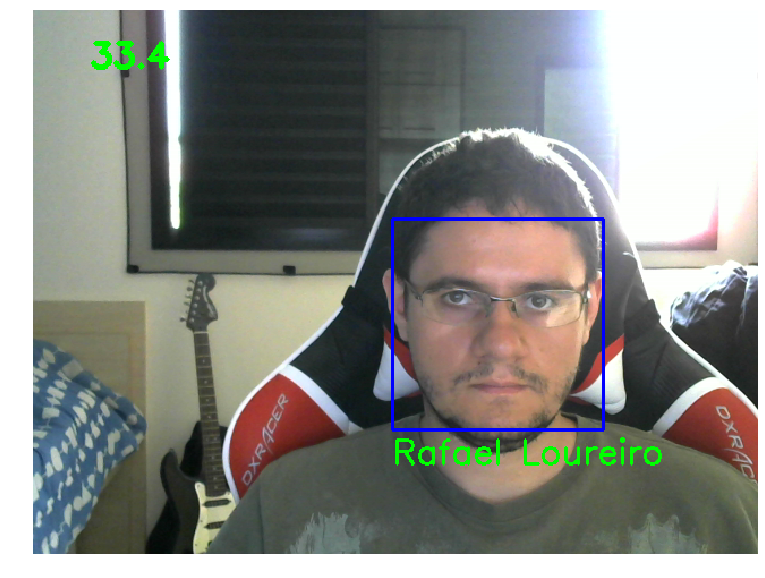

In [22]:
# IMPLEMENTAR
# Passe o parâmetro localização da imagem para exibi-la no notebook

exibir_imagem("imagens/success_candidate.png")

## 3. Detector de sorriso

Muitas empresas demandam que futuros empregados demonstrem educação, tranquilidade e empatia, características que podem ser evidencias com uma uma análise simples da receptividade do candidado por meio das expressões de seu rosto.

Um detector importante disto é sobre se o candidato mantém o semblante fechado ou se mantém um rosto alegre, oscilando sorrisos a medida que é realizada a entrevista e demais questionamentos.

Utilize as bibliotecas do _DLib_, em especial o preditor treinado para 68 pontos de marcação de face, para identificar a geometria dela e obtenha as marcações de interesse.

Uma das formas de extraírmos os pontos de contorno da face é utilizando o modelo do _DLib_ ```shape_predictor_68_face_landmarks.dat```. Este modelo retorna 68 pontos da face

In [3]:
import dlib
import numpy 

predictor_68_path = "modelos/shape_predictor_68_face_landmarks.dat"

predictor = dlib.shape_predictor(predictor_68_path)
detector = dlib.get_frontal_face_detector()

Liste os pontos de cada parte do rosto. A partir deles poderão ser feitos estudos geométricos para identificar características relacioandos aos mesmos.

In [4]:
# IMPLEMENTAR
# Para cada constante abaixo, indique uma lista de pontos dos 68 identificados pelo classificador do DLib
FACE_POINTS = list(range(17, 68))
MOUTH_POINTS = list(range(48, 61))
RIGHT_BROW_POINTS = list(range(17, 22))
LEFT_BROW_POINTS = list(range(22, 27))
RIGHT_EYE_POINTS = list(range(36, 42))
LEFT_EYE_POINTS = list(range(42, 48))
NOSE_POINTS = list(range(27, 35))
JAW_POINTS = list(range(0, 17))

Crie uma função que será utilizada para identificar um sorriso. Leve em consideração estudos que envolvem cálculo de razão de aspecto geométrico e adapte para os pontos dos lábios.

Estude o paper de [Soukupová e Čech de 2016](http://vision.fe.uni-lj.si/cvww2016/proceedings/papers/05.pdf) para entender como obter um cálculo de aspecto de razão para formas geométricas da face. Você pode fazer aproximações a partir do estudo do paper para outras formas, como os lábios e olhos.

Crie uma função ```month_aspect_ratio``` que receba os pontos dos lábios e calcule o aspecto de razão para que seja exibida dados de quando a boca está aberta, fechada, dentre outros comportamentos.

In [5]:
def mouth_aspect_ratio(mouth):
    
    # IMPLEMENTAR
    # Utilize referências do paper para calcular o MAR (Mouth Aspect Ratio)
    a = dist.euclidean(mouth[1], mouth[10])
    b = dist.euclidean(mouth[2], mouth[9])
    c = dist.euclidean(mouth[5], mouth[7])
    d = dist.euclidean(mouth[4], mouth[8])
 
    e = dist.euclidean(mouth[0], mouth[6])
 
    mar = (a + b + c + d) / (4.0 * e)
    
    return mar

Na função abaixo, inclua um segundo retorno que será a razão de aspecto dos lábios. Deixe como está o terceiro retorno, pois ele será estudado no próximo algoritmo.

In [7]:
def annotate_landmarks_convex_hull_image(im):
    im = im.copy()
    rects = detector(im, 1)
    
    if len(rects) == 0:
        return im, 0, 0
    
    landmarks_list = []
    
    for rect in rects:
        landmarks = numpy.matrix([[p.x, p.y] for p in predictor(im, rect).parts()])

        for k, d in enumerate(rects):
            cv2.rectangle(im, (d.left(), d.top()), (d.right(), d.bottom()), (0, 255, 0), 2)

            points = cv2.convexHull(landmarks[NOSE_POINTS])
            cv2.drawContours(im, [points], 0, (0, 255, 0), 1)

            points = cv2.convexHull(landmarks[MOUTH_POINTS])
            cv2.drawContours(im, [points], 0, (0, 255, 0), 1)
            
            points = cv2.convexHull(landmarks[RIGHT_BROW_POINTS])
            cv2.drawContours(im, [points], 0, (0, 255, 0), 1)

            points = cv2.convexHull(landmarks[LEFT_BROW_POINTS])
            cv2.drawContours(im, [points], 0, (0, 255, 0), 1)

            points = cv2.convexHull(landmarks[RIGHT_EYE_POINTS])
            cv2.drawContours(im, [points], 0, (0, 255, 0), 1)
            
            points = cv2.convexHull(landmarks[LEFT_EYE_POINTS])
            cv2.drawContours(im, [points], 0, (0, 255, 0), 1)
            
            mouth_aspect = mouth_aspect_ratio(landmarks[MOUTH_POINTS])
            eye_aspect = eye_aspect_ratio(landmarks[RIGHT_EYE_POINTS])

    return im, mouth_aspect, eye_aspect

Realize ensaios para definir o valor de sorriso versos simulações com os lábios normais e aberto. Um sorriso é uma estado entre os lábios fechados ou semi-fechados e a boca inteiramente aberta.
Definina abaixo os limiares inferior e superior para a identificação de um sorriso.

In [8]:
# IMPLEMENTAR
# Defina os valores mínimo e máximo para detecção do sorriso

sorriso_minimo = 0.170
sorrimo_maximo = 0.205

Após identificar o sorriso, contabilize quantas vezes foram identificados.

In [9]:
cam_capture = cv2.VideoCapture(0)
cv2.destroyAllWindows()

# Quantidade de sorrisos identificados
qtde_sorrisos = 0
sorrindo = False

while True:
    ret, image_frame = cam_capture.read()
    
    if ret:
        image_frame, mouth_aspect, _ = annotate_landmarks_convex_hull_image(image_frame)
        
        # IMPLEMENTAR
        # Defina o algoritmo que irá identificar o sorriso baseado nos limites defindos
        # Crie uma lógica para contar quantas vezes o sorriso foi dado
        if mouth_aspect >= sorriso_minimo and mouth_aspect <= sorrimo_maximo:
            if sorrindo == False:
                qtde_sorrisos += 1
                cv2.imwrite("imagens/smile_detected.png", image_frame)
                sorrindo = True
        else:
            sorrindo = False
        
        cv2.putText(image_frame, '{0:.3g}'.format(mouth_aspect), (50,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 3)
        cv2.putText(image_frame, str(qtde_sorrisos), (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 3)
        cv2.imshow("Detector de Sorriso", image_frame)
        
        # Se for teclado Enter (tecla 13) deverá sair do loop e encerrar a captura de imagem   
        if cv2.waitKey(1) == 13:
            break
    else:
        break
        
cam_capture.release()
cv2.destroyAllWindows()

Armazene um exemplo de uma imagem, na pasta ```imagens``` com o sorriso detectado para exibição.

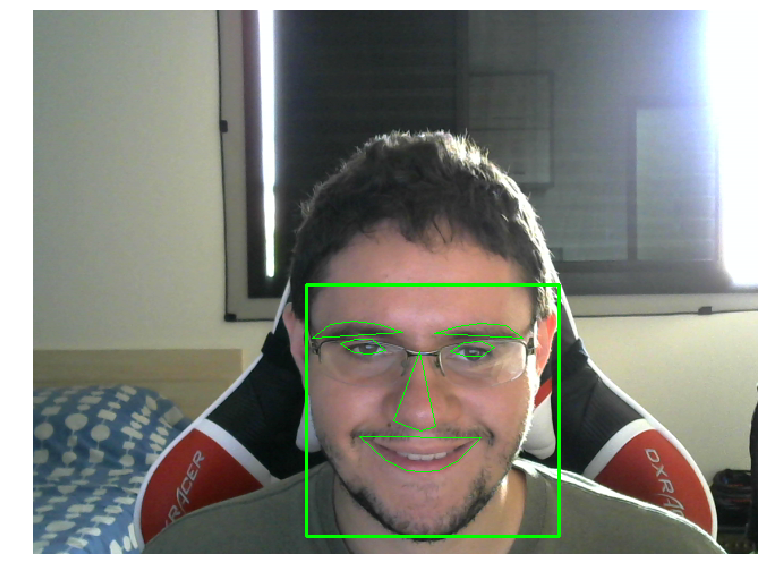

In [10]:
# IMPLEMENTAR
# Passe o parâmetro localização da imagem para exibi-la no notebook

exibir_imagem("imagens/smile_detected.png")

## 4. Detector de bocejos

Os candidados devem estar sempre atentos durante a entrevista virtual. Para garantir que ele se preparou adequadamente antes do início da entrevista não deverá ser tolerado bocejos.

Um detector de bocejos deverá utilizar aspectos das marcações dos lábios já definidas para identificar o bocejo. Neste caso o que será diferente é o valor da razão de aspecto.

Neste caso não há um limiar, como o bocejo é a boca aberta ao máximo, vamos definir um valor mínimo.

In [11]:
# IMPLEMENTAR
# Defina o valor mínimo de abertura dos lábios

bocejo_minimo = 0.550

In [12]:
cam_capture = cv2.VideoCapture(0)
cv2.destroyAllWindows()

# Quantidade de bocejos identificados
qtde_bocejos = 0
bocejando = False

while True:
    ret, image_frame = cam_capture.read()
    
    if ret:
        image_frame, mouth_aspect, _ = annotate_landmarks_convex_hull_image(image_frame)
        
        # IMPLEMENTAR
        # Defina o algoritmo que irá identificar o bocejo baseado no limite defindo
        # Crie uma lógica para contar quantas vezes o bocejo foi dado
        if mouth_aspect >= bocejo_minimo:
            if bocejando == False:
                qtde_bocejos += 1
                cv2.imwrite("imagens/yawn_detected.png", image_frame)
                bocejando = True
        else:
            bocejando = False
        
        cv2.putText(image_frame, '{0:.3g}'.format(mouth_aspect), (50,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 3)
        cv2.putText(image_frame, str(qtde_bocejos), (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 3)
        cv2.imshow("Detector de Bocejos", image_frame)
       
        # Se for teclado Enter (tecla 13) deverá sair do loop e encerrar a captura de imagem   
        if cv2.waitKey(1) == 13:
            break
    else:
        break
        
cam_capture.release()
cv2.destroyAllWindows()

Armazene um exemplo de uma imagem, na pasta ```imagens``` com o bocejo detectado para exibição.

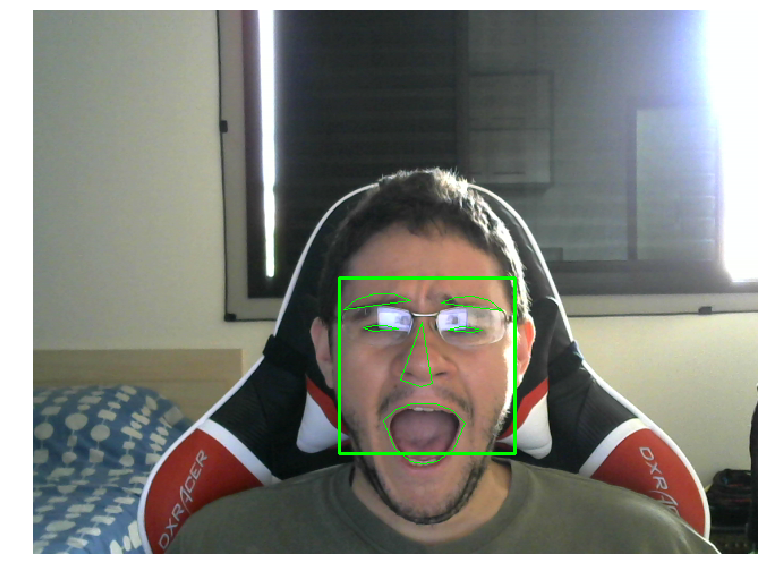

In [13]:
# IMPLEMENTAR
# Passe o parâmetro localização da imagem para exibi-la no notebook

exibir_imagem("imagens/yawn_detected.png")

## 5. Detector de olhos fechados

A atenção durante um processo de entrevista é algo crucial, e mais marcante neste etapa do processo seletivo. Por esta razão é preciso identificar a quantidade de vezes que o entrevistado feche os olhos, para entendermos se ele de fato está atento as perguntas e ao processo como um todo.

Elabore um algoritmo que detecte os olhos fechados e contabilize ao final da transmissão.

Este caso requer um estudo também geométrico que visa analisar os pontos da marcação dos olhos. Para fins de simplificação, podemos adotar um único olho, e a partir dele, estebelecer o razão de aspecto para quando ele está aberto e fechado.

Construa uma função chamada ```eye_aspect_ratio``` para calcular o aspecto de razão de um dos olhos.

In [6]:
def eye_aspect_ratio(eye):
    
    # IMPLEMENTAR
    # Calcule o EAR (Eye Aspect Ratio) que determina o aspecto de razão da geometria de um dos olhos
    a = dist.euclidean(eye[1], eye[5])
    b = dist.euclidean(eye[2], eye[4])
    
    c = dist.euclidean(eye[0], eye[3])
 
    ear = (a + b) / (2.0 * c)
    
    return ear

Altere a função ```annotate_landmarks_convex_hull_image``` para exibir, no terceiro parâmetro o valor de aspecto de um dos olhos.

No caso do olho, precisamos definir somente um valor máximo de limite.

In [14]:
# IMPLEMENTAR
# Defina um valor máximo para determinar se o olho está fechado
olho_maximo = 0.1
olho_tempo_maximo = 0.2

In [15]:
from chronometer import Chronometer

cam_capture.release()
cam_capture = cv2.VideoCapture(0)
cv2.destroyAllWindows()

#Quantidade de olhos fechados identificados
qtde_olhos_fechados = 0
olho_fechado = False
cron_olho_fechado = Chronometer()

while True:
    ret, image_frame = cam_capture.read()
    
    if ret:
        image_frame, _, eye_aspect = annotate_landmarks_convex_hull_image(image_frame)
        
        # IMPLEMENTAR
        # Defina o algoritmo que irá identificar se um olho está fechado baseado no limite defindo
        # Crie uma lógica para contar quantas vezes o olho foi fechado
        if eye_aspect <= olho_maximo and eye_aspect > 0:
            if not olho_fechado:
                cron_olho_fechado.start()
                olho_fechado = True
        else:
            if olho_fechado:
                cron_olho_fechado.stop()
                if float(cron_olho_fechado) > olho_tempo_maximo:
                    qtde_olhos_fechados += 1
                cron_olho_fechado.reset()
                olho_fechado = False
        
        cv2.putText(image_frame, '{0:.3g}'.format(eye_aspect), (50,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 3)
        cv2.putText(image_frame, str(qtde_olhos_fechados), (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 3)
        cv2.imshow("Detector de Olhos Fechados", image_frame)
        
        # Se for teclado Enter (tecla 13) deverá sair do loop e encerrar a captura de imagem  
        if cv2.waitKey(1) == 13:
            break
    else:
        break
        
cam_capture.release()
cv2.destroyAllWindows()

## 6. Descritor de objetos na cena

A organização do local na casa do entrevistado é um item relevante, pois a partir destes detalhes é possível traçar alguns tipos de perfis que são essenciais para certas posições nas empresas.

Desta forma precisamos construir um algoritmo que realize uma inspeção de objetos na área da câmera que é utilizada para fazer a entrevista. Ao final mostre quais e quantos objetos foram detectados.

É necessário baixar os pesos (modelo de deep-learning) neste link https://pjreddie.com/media/files/yolov3.weights e copiar para  pasta weights.

In [16]:
from utils import *
from darknet import Darknet

# Configurações na rede neural YOLOv3
cfg_file = 'cfg/yolov3.cfg'
m = Darknet(cfg_file)

# Pesos pré-treinados
weight_file = 'weights/yolov3.weights'
m.load_weights(weight_file)

# Rótulos de classes
namesfile = 'data/coco.names'
class_names = load_class_names(namesfile)

Ajuste os valores de NMS (_Non-Maximum Supression_) para regular a sensibilidade de imagens com baixa luminosidade e IOU (_Intersect of Union_) que definie o indicador se o retângulo de identificação de imagem foi adequadamente desenhado.

In [17]:
# IMPLEMENTAR
# Definia apropriadamente os valores de limiar de NMS e IOU

nms_thresh = 0.6
iou_thresh = 0.4

Separe um imagem que será analisada pelo classificador, após teclar o _Enter_. Armazene no diretório ```imagens/local-entrevista.png```.

In [18]:
cam_capture = cv2.VideoCapture(0)

while True:
    ret, image_frame = cam_capture.read()
    
    if ret:
        cv2.imshow("Inspecao Local", image_frame)
        
        # IMPLEMENTAR
        # Após teclar enter, armazene uma imagem para posterior análise
        if cv2.waitKey(1) == 13:
            cv2.imwrite("imagens/object_analysis.png", image_frame)
            break
        
cam_capture.release()
cv2.destroyAllWindows()

A imagem a ser analisada.

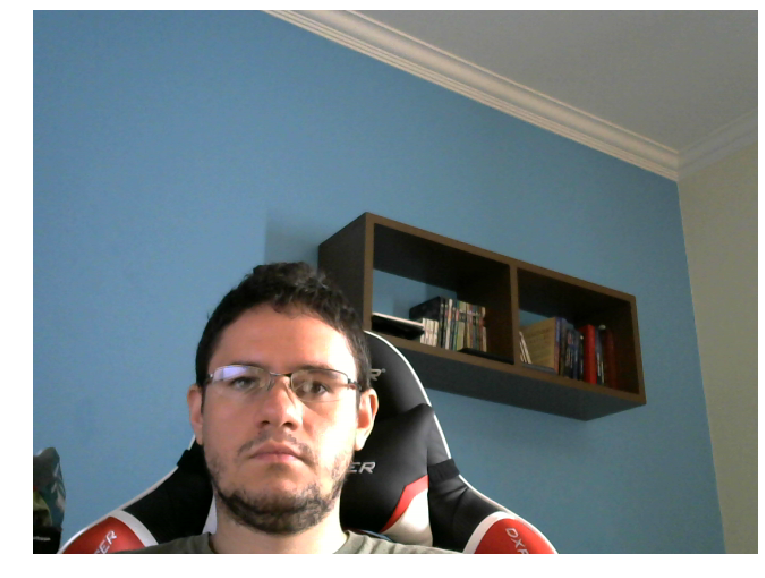

In [19]:
# IMPLEMENTAR
# Altere abaixo o parâmetro de entrada para o caminho onde a imagem foi armazenada

exibir_imagem("imagens/object_analysis.png")

Os passos abaixo são para configuração da imagem no padrão que o classificador foi treinado.

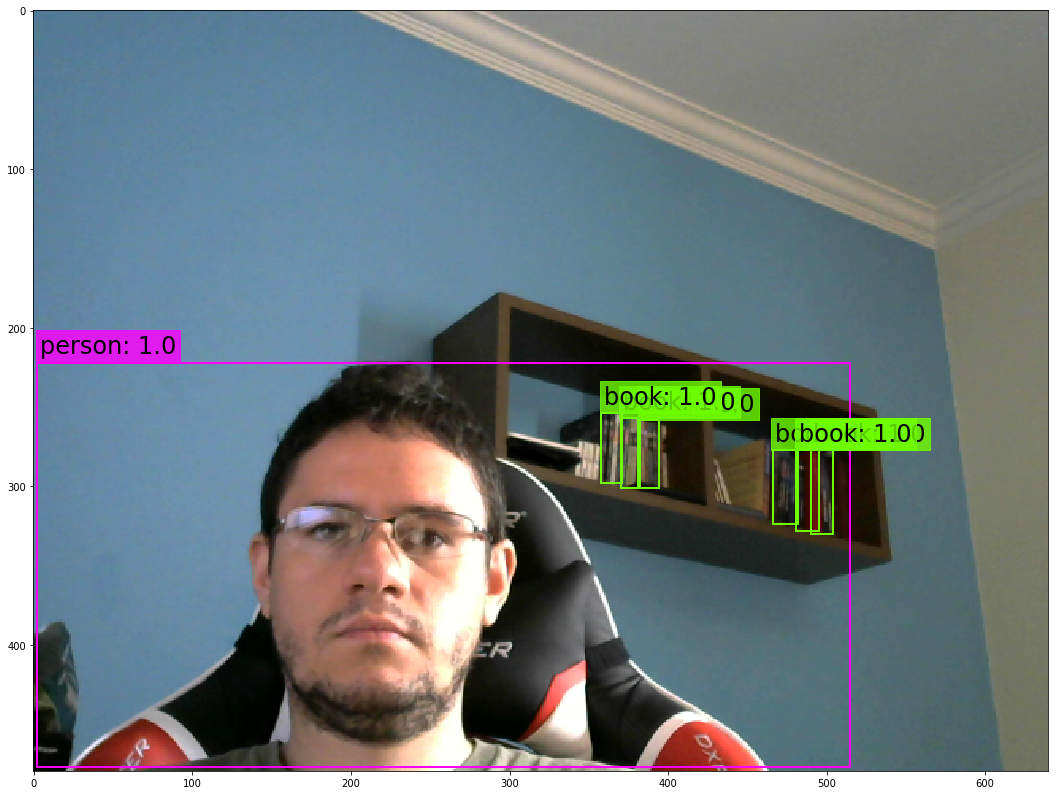

In [20]:
# Definindo tamnaho do gráfico
plt.rcParams['figure.figsize'] = [24.0, 14.0]

# Carregar imagem para classificação
img = cv2.imread("imagens/object_analysis.png")

# Conversão para o espaço RGB
original_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Redimensionamento para adatapção da primeira camada da rede neural 
resized_image = cv2.resize(original_image, (m.width, m.height))

# Deteteção de objetos na imagem
boxes = detect_objects(m, resized_image, iou_thresh, nms_thresh)

# Desenho no gráfico com os regângulos e rótulos
plot_boxes(original_image, boxes, class_names, plot_labels = True)

Obtenha os objetos identificados a partir da função ```list_objects(boxes, class_names)```. Será retornardo uma lista de objetos que deverá ser analisado para contar a quantidade de cada objeto. Se houver mais de um item igual, por exemplo _tvmonitor_ ele aparecerá duplicado na imagem.

In [21]:
# IMPLEMENTAR
# Conte os objetos identificados pelo classificador, de forma que seja exibido 
# objeto 1, quantidade 1
# objeto 2, quantidade 1
# ...
from itertools import groupby

objetos = list_objects(boxes, class_names)
agrupamento = [[key, len(list(group))] for key, group in groupby(objetos)]
agrupamento

[['person', 1], ['book', 6]]

## Conclusões finais

**Pergunta:** Diante de todos os desafios propostos (1 ao 6) e soluções encontradas, quais seriam os próximos passos de forma a tornar mais precisos cada atividade, levando em consideração: (1) restrições de processamento em tempo real, (2) sem restrições de processamento em tempo real?

**Resposta**:  
Considerando restrições de processamento em tempo real é mais complicado, o ideal é utilizar algoritmos mais rápidos e evitar redes neurais que são um pouco mais lentas. O ideal é utilizarmos soluções como as que usamos para detecção do sorriso, bocejo e olhos fechados que utilizam um cálculo simples de aspect ratio e não exigem muito processamento. Poderíamos também melhorar ainda mais a precisão de alguns algoritmos como o de detecção de sorriso, verificando também o alinhamento dos pontos superiores da boca para ter um resultado mais preciso, ou na detecção do bocejo onde também poderíamos verificar o eye aspect ratio, pois normalmente quando bocejamos nossos olhos também fecham um pouco.
Sem restrição de processamento em tempo real seria muito mais simples pois poderíamos simplesmente armazenar os vídeos das entrevistas para fazer a análise posteriormente. Desta forma conseguiríamos analisar com mais detalhes as imagens pois não seria necessário o processamento em tempo real e ficaríamos menos limitados ao uso de determinados algoritmos.